In [2]:
%matplotlib inline

In [3]:
import numpy as np
import cv2 
import stripes.palette as palette
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')

reload(palette)

<module 'stripes.palette' from 'stripes/palette.pyc'>

In [4]:
import os
import pandas as pd

In [5]:
def create_random_stripe(image_name):
    plt.ioff()
    fig = plt.figure(figsize=(12, 2))
    template = np.ones((48, 48, 3))
    color = np.array((255, 255, 255))
    img = (template * color).astype('uint8')
    plt.subplot(1, len(palette.agents_list) + 5, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.text(x=1,y=16,s=os.path.basename(image_name),fontsize=16)
    plt.subplot(1, len(palette.agents_list) + 5, 2)
    plt.imshow(img)
    plt.axis('off')
    
    row_dict = {'N': image_name}
    
    for i,agent in enumerate(palette.agents_list):
        plt.subplot(1, len(palette.agents_list) + 5, 4 + i)
        if agent != 'BLO':
            index = np.random.randint(0, high=len(palette.points_dict[agent]))
        else:
            index = np.random.choice([0, 3, 4, 5, 6])
        template = np.ones((48, 48, 3))
        color = np.array(palette.points_dict[agent][index])
        img = (template * color).astype('uint8')
        plt.imshow(img)
#         plt.title("{}\n{}".format(agent, index))
        plt.axis('off')
        plt.subplots_adjust(wspace=0.01, top=2.0, bottom=0.5)
        row_dict.update({agent: palette.targets_dict[agent][index]})

    plt.tight_layout()
    
    plt.savefig(image_name,bbox_inches = 'tight',pad_inches=0.1)

    img = cv2.imread(image_name)
    img[0:3,:,:] = 0
    img[:,0:3,:] = 0
    img[:,-3:,:] = 0
    img[-3:,:,:] = 0
    cv2.imwrite(image_name,img)
    plt.close()
    
    return row_dict

In [12]:
!mkdir random_stripes

mkdir: cannot create directory ‘random_stripes’: File exists


In [37]:
path = "random_stripes/"

In [38]:
def generate_stripes(n_to_generate):
    data = pd.DataFrame(columns=['N'] + palette.agents_list)
    
    for i in xrange(n_to_generate):
        basename = str(i) + '.png'
        full_name = os.path.join(path,basename)
        data = data.append(create_random_stripe(full_name), ignore_index=True)

    return data 

In [39]:
data = generate_stripes(n_to_generate = 1)

In [32]:
data.to_csv(os.path.join(path,"data.csv"), sep=';')

#### TODO: можно сделать генерацию через opencv, так будет гораздо быстрее

## Ахтунг
Ниже идёт **хардкод**, чтобы склеивать только что созданные картинки. Никаких констант. Если нужно что-то более кастомизируемое, то лучше переделать. Для 100 картинок точно нормально работает (можно ещё вариант с генерацией 10 картинок по 10 полосок)

In [35]:
img = cv2.imread(os.path.join(path,'0.png'))

In [36]:
k = img.shape[0]

for i in xrange(5):
    full_img_name = "full_{}.png".format(i)
    full_img = np.zeros((img.shape[0]*20,img.shape[1],img.shape[2]))
    
    
    for j in xrange(20):
        name = "{}.png".format(20*i + j)

        
        img_to_stack = cv2.imread(os.path.join(path,name))
        
        full_img[j*k:(j+1)*k,:,:]= img_to_stack
    cv2.imwrite(os.path.join(path,full_img_name),full_img)

In [37]:
plt.ion()

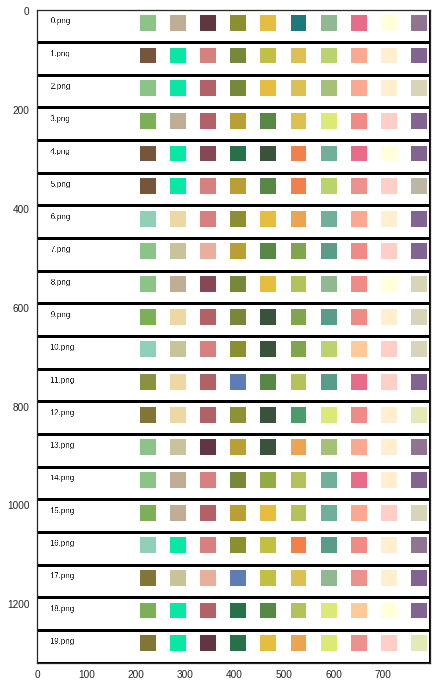

In [38]:
plt.figure(figsize=(8,12))
img = cv2.imread(os.path.join(path,'full_0.png'))
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

`с OpenCV`:

In [57]:
def make_template(height=50, width=1200, left_margin=500, pool_side=40, n_pools=10):
    
    template = (np.ones((height + 1, width, 3)) * 255).astype(np.uint8)
    cv2.rectangle(template, (0, 0), (width-1, height), (0, 0, 0), 1)
    
    top_margin = (height - pool_side) / 2
    pool_margin = (width - left_margin) / n_pools - pool_side
    
    coords = []
    for i in xrange(n_pools):
        coords.append((left_margin + i * (pool_side + pool_margin) + (pool_side / 2), height / 2))
        cv2.rectangle(template, (left_margin + i * (pool_side + pool_margin), top_margin),
                             (left_margin + i * (pool_side + pool_margin) + pool_side, height - top_margin),
                     (0, 0, 0), 1)
        
    # возврат шаблона и списка координат центров ячеек
    return template, coords

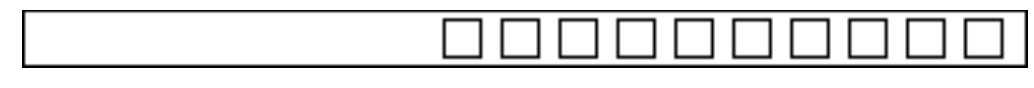

[(144, 9), (163, 9), (182, 9), (201, 9), (220, 9), (239, 9), (258, 9), (277, 9), (296, 9), (315, 9)]


In [58]:
template, coords = make_template(18, 330, 138, 12)

plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(template)
plt.show()
print coords

In [59]:
def fill_template(template, coords, colors):
    colored_template = template.copy()
    for j, (x, y) in enumerate(coords):
        cv2.floodFill(colored_template, None, (x, y), colors[j])
    return colored_template

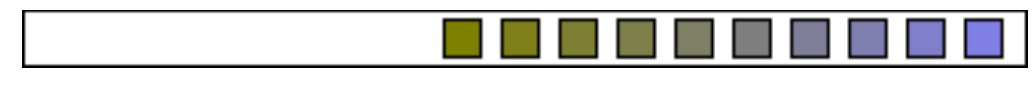

In [60]:
colored_template = fill_template(template, coords, [(127, 127, i * 255 / 10) for i in xrange(10)])

plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(colored_template)
plt.show()

In [61]:
def entitle_template(template, title):
    pos = 50, int(template.shape[0] * 2. / 3)
    entitled_template = template.copy()
    cv2.putText(entitled_template, title, pos, cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0))
    return entitled_template

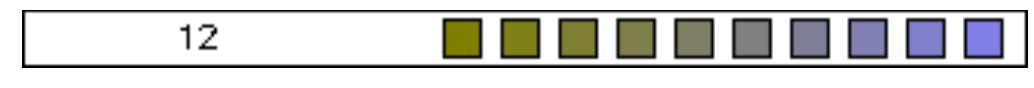

In [62]:
ready_template = entitle_template(colored_template, "12")
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(ready_template)
plt.show()

In [70]:
def create_random_stripe_(image_name):
    row_dict = {'N': image_name}
    colors = []
    for i,agent in enumerate(palette.agents_list):
        if agent != 'BLO':
            index = np.random.randint(0, high=len(palette.points_dict[agent]))
        else:
            index = np.random.choice([0, 3, 4, 5, 6])
        colors.append(palette.points_dict[agent][index])        
        row_dict.update({agent: palette.targets_dict[agent][index]})
    template, coords = make_template(18, 330, 138, 12, n_pools=len(palette.agents_list))            
    colored_template = fill_template(template, coords, colors[::-1])
    entitled_template = entitle_template(colored_template, image_name)
    return entitled_template, row_dict

In [71]:
cl, rd = create_random_stripe_("1488")

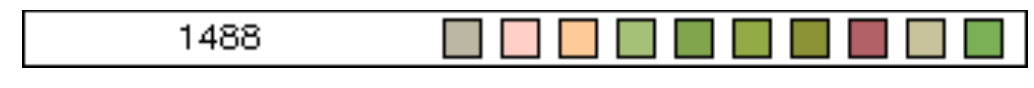

{'BIL': 2, 'PRO': 1, 'URO': 0.2, 'N': '1488', 'BLO': 3, 'LEU': 1, 'pH': 7.5, 'KET': 40, 'SG': 1.02, 'GLU': 250, 'NIT': 1}


In [72]:
plt.figure(figsize=(18, 5))
plt.axis('off')
plt.imshow(cl)
plt.show()

print rd

In [73]:
def create_table(n_strips=5, names=None, add_space=False):
    if names is None:
        names = ["{}.png".format(j) for j in xrange(n_strips)]
    assert len(names) == n_strips
    
    strips = []
    data = pd.DataFrame(columns=['N'] + palette.agents_list)
    
    for j in xrange(n_strips):
        strip, row = create_random_stripe_(names[j])
        data = data.append(row, ignore_index=True)
        if add_space:
            space = np.zeros(shape=(10, strip.shape[1], 3), dtype=np.uint8) + 255
            strips.append(space)
        strips.append(strip)
    strips.append(space)    
    return np.concatenate(strips, axis=0), data

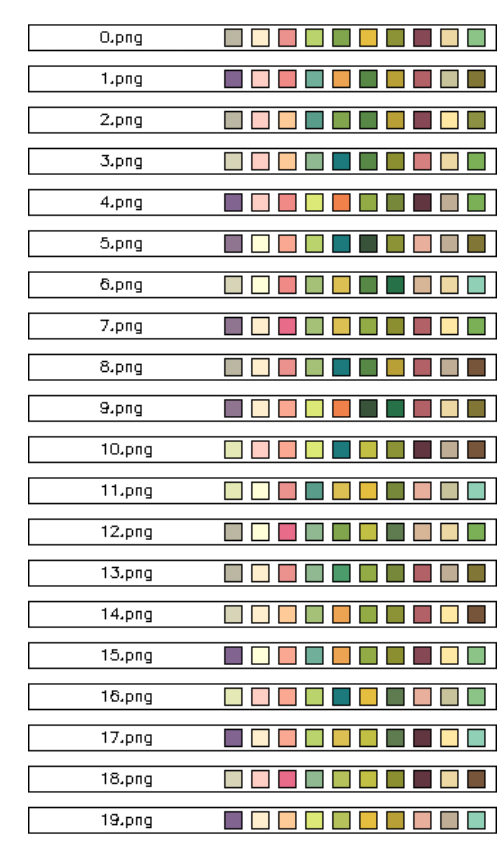

,N,GLU,BIL,KET,SG,BLO,pH,PRO,URO,NIT,LEU
0,0.png,100,1,80,1.020,-1,7.5,0,2,0,1
1,1.png,1000,2,40,1.030,4,6.0,3,4,1,3
2,2.png,500,-1,80,1.030,4,7.5,4,0.2,1,1
3,3.png,250,1,15,1.025,4,8.5,2,0.2,1,0
4,4.png,250,3,160,1.015,3,5.0,-1,4,1,3


In [74]:
table, data = create_table(20, add_space=True)

plt.figure(figsize=(25, 15))
plt.axis('off')
plt.imshow(table)
plt.show()

data.head()

In [75]:
cv2.imwrite("table_compact.png", cv2.cvtColor(table, cv2.COLOR_RGB2BGR))

True

In [76]:
data.to_csv("table_compact.csv", sep=';')